# Tutorial 1: Solving an ordinary differential equation

In this notebook, we will use of the `numpy` and `scipy` packages to solve an ordinary differential equation(ODE). Then, we will illustrate how to solve many ODEs in parallel using the `concurrent` module.

The `numpy` and `scipy` APIs are well documented with many examples:
* The Scipy [documentation](https://docs.scipy.org/doc/scipy/reference/index.html#)
* The Numpy [documentation](https://docs.scipy.org/doc/numpy-1.13.0/reference/index.html)

We will make use of the [odeint](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html#scipy.integrate.odeint) module from the `scipy` package to integrate the ODE. Let's first import the necessary packages:

In [50]:
# Imports
import time
import numpy as np
from scipy.integrate import odeint 
from sklearn.model_selection import ParameterGrid
import concurrent.futures 
import matplotlib.pyplot as plt

# Plots will appear in the notebook
%matplotlib inline 

Let's solve the following second order ODE:

$$ \frac{d^2 \theta}{d t^2} + b\, \frac{d \theta}{d t} + c\, \sin\theta  = 0 $$

The usual method involves re-writing it as a system of 1st order equations:

$$ \frac{d \theta}{d t} = \omega $$

$$ \frac{d \omega}{d t} = -b \omega - c \sin\theta $$

In [51]:
## Equations to be integrated
def eom(y, t, b, c):
    """
    y   : [th, om] where om = d(th)/dt
    t   : time (sec)
    b,c : parameters 
    """
    th, om = y

    # Equations
    dot_th = om
    dot_om = -b*om - c*np.sin(th)

    # Return as a list
    return [dot_th, dot_om]

Let's specify the time `t` the independent variable of the ODE, as well as the parameters `b` and `c`. For a unique solution, we need to specify two initial conditions, $\theta(t=0)$ and $\omega(t=0)$:

In [52]:
help(eom)

Help on function eom in module __main__:

eom(y, t, b, c)
    y   : [th, om] where om = d(th)/dt
    t   : time (sec)
    b,c : parameters



In [53]:
# Specity t
duration = 90
npts = 401

# Choose the parameters in the equation
b = 0.05
c = 4.0

# Time grid
t = np.linspace(0,duration,npts)

# Solve for a given set of initial conditions
init_conds = [0.25*np.pi, 0.5]
sol = odeint(eom, init_conds, t, args = (b, c))


The solution is saved in array `sol`. The first column is $\theta$ second one is $d\theta / dt$:

np.pi is just the value of $\pi$

In [54]:
np.pi

3.141592653589793

In [55]:
sol.shape

(401, 2)

The first 20 entries for $\theta$ and $\omega$:

In [56]:
sol[:20]

array([[ 0.78539816,  0.5       ],
       [ 0.82416595, -0.15816699],
       [ 0.71642907, -0.78676721],
       [ 0.47968059, -1.28744388],
       [ 0.1546476 , -1.55493014],
       [-0.19695814, -1.51778159],
       [-0.50622808, -1.18838114],
       [-0.71638353, -0.65492671],
       [-0.79387853, -0.0266746 ],
       [-0.72863297,  0.59840341],
       [-0.53192866,  1.12531162],
       [-0.23728908,  1.45214512],
       [ 0.10022568,  1.4973683 ],
       [ 0.4143281 ,  1.24955497],
       [ 0.64559812,  0.77718577],
       [ 0.75505365,  0.18435869],
       [ 0.72701143, -0.42937516],
       [ 0.56724436, -0.97068587],
       [ 0.30301354, -1.34141482],
       [-0.01696083, -1.45505311]])

You can also select only the solution for $\theta$ by (the first 10 in time):

In [57]:
sol[:10,0]

array([ 0.78539816,  0.82416595,  0.71642907,  0.47968059,  0.1546476 ,
       -0.19695814, -0.50622808, -0.71638353, -0.79387853, -0.72863297])

Let's plot the solution using Matplotlib:

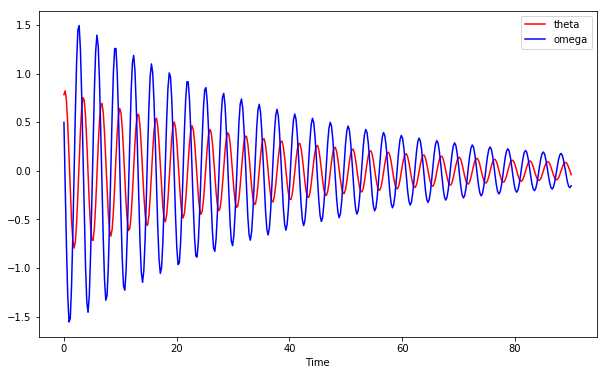

In [58]:
# Setup the figure 
plt.figure(figsize=(10,6))
plt.plot(t, sol[:,0], 'r-', label='theta') # theta
plt.plot(t, sol[:,1], 'b-', label='omega') # theta'
plt.xlabel('Time')
plt.legend()
plt.show()

## Solve the ODE for a given range of initial conditions:

Suppose we want to integrate this equation for a large number of initial conditions. For this example this is not very interesting, but suppose you are modeling a complex system which has high sensitity to initial conditions (e.g. climate modelling). Then, you may want to screen the solution for a large number of initial conditions. As a concrete example, check out the [Lorenz attractor](https://en.wikipedia.org/wiki/Lorenz_system).

Let's define a function that returns a grid of initial conditions given a range of initial conditions for $\theta(t=0)$ and $\omega(t=0)$:

In [59]:
## Function to set the grid for the initial condition space
# Notice that the function specifies default values as well
def set_parameter_grid(rTh = (-0.25*np.pi, 0.25*np.pi), rOm = (-1,1), size = 100):
    """
    Function for creating a grid of initial conditions
    rTh    : range of th (-0.25*pi,0.25*pi)
    rOm    : range of om
    size   : Number of samples per theta and omega

    Returns a dictionary containing a grid of initial conditions
    """
    ths = np.random.uniform(rTh[0], rTh[1], size)
    oms = np.random.uniform(rOm[0], rOm[1], size)

    param_grid = {'th0':ths, 'om0':oms}
    grid = ParameterGrid(param_grid)

    return grid

This function chooses random initial conditions from a uniform distributuion. Then, it creates a grid of all possible initial condition combinations. As a result, we will be screening a space of `size x size` initial conditions:

In [60]:
init_conds = list(set_parameter_grid(size=50))
totlen = len(init_conds)

Let's look at the first ten initial conditions to be used:

In [61]:
init_conds[:10]

[{'om0': 0.94239791771356596, 'th0': -0.26198101044476851},
 {'om0': 0.94239791771356596, 'th0': -0.67180700678507677},
 {'om0': 0.94239791771356596, 'th0': -0.10076303272208731},
 {'om0': 0.94239791771356596, 'th0': -0.087972928215723445},
 {'om0': 0.94239791771356596, 'th0': 0.68468602656190214},
 {'om0': 0.94239791771356596, 'th0': -0.050521387062154033},
 {'om0': 0.94239791771356596, 'th0': -0.31106310865521319},
 {'om0': 0.94239791771356596, 'th0': -0.68414478613367014},
 {'om0': 0.94239791771356596, 'th0': 0.65223188212776617},
 {'om0': 0.94239791771356596, 'th0': 0.38967984722526339}]

This is a **list** of **dictionaries**. For example, to get the first in the list, you can use:

```python
init_conds[0]['om0']
```

will give the first initial condition for $\omega$ and the corressponding for $\theta$ is:

```python
init_conds[0]['th0']
```

Let's now integrate the ODE for all the initial conditions in the list in a `for loop`:

In [62]:
# Initiate empty array to save solutions
dofs = np.zeros((totlen, len(t), 2))

# Loop over all initial conditions and integrate
ii = 0
start_t = time.time()
for params in init_conds:
    y0 = [params['th0'], params['om0']]
    sol = odeint(eom, y0, t, args = (b, c))
    
    # Save
    dofs[ii] = sol
    ii +=1

execution_t = time.time() - start_t

The total time it takes to complete:

In [63]:
print("Execution time: {:.4f} s".format(execution_t))

Execution time: 29.2957 s


For each 50x50 initial conditions, we have integrated the ODE to obtain solutions for $\theta$ and $\omega$. The resulting array we have saved has the following dimensions:

In [64]:
dofs.shape

(2500, 401, 2)

The solution for the first set of initial conditions can be obtained by

```python
dofs[0]
```

The second set of initials conditions by

```python
dofs[1]
```

etc..

## Solve the ODE for a given range of initial conditions (parallel):

Now, let's do the same thing in parallel. Your laptop contains more than a single core, so why not use them all?

First we need to wrap what we did above in a function in order to pass it to a parallel executor:

In [65]:
# Simulate for all the initial conditions
def simulate_all(init_conds):
    """
    Simulate for a grid of initial conditions
    """
    
    # Get grid size
    totlen = len(init_conds)
    
    # Initiate empty array
    dofs = np.zeros((totlen, len(t), 2))
    
    # Iterate
    ii = 0
    for params in init_conds:
        y0 = [params['th0'], params['om0']]
        sol = odeint(eom, y0, t, args = (b, c))

        # Save on dofs array
        dofs[ii] = sol
        ii +=1

    # Return
    return dofs

**Important** : Notice that b,c are not defined in the function itself! Python first looks for the variables within the function, and then in the enclosing environment (lexical scoping).

The above function will be called on a list of initial conditions. Each element in the list contains a subset of initial conditions and the parallel executor will process then concurrently:

In [66]:
# Parallel executor
executor = concurrent.futures.ProcessPoolExecutor()
n_workers = executor._max_workers
case_per_worker = totlen // n_workers

# Print report
print("Total number of workers = {:d}".format(n_workers))
print("Instances per worker = {:d}".format(case_per_worker))

# Split the list of initial conditions between the workers
splits = []
for w in range(n_workers):
    splits.append(init_conds[w*case_per_worker:(w+1)*case_per_worker])


Total number of workers = 4
Instances per worker = 625


`splits` is a *list of lists* and contains the following (explictly):

```python
splits[0] : init_conds[0:625]
splits[1] : init_conds[625:1250]
splits[2] : init_conds[1250:1875]
splits[3] : init_conds[1875:25000]
```

Let's have the `executor` *map* `simulate_all` on all the splits in parallel:

In [67]:
# Obtain results in parallel
start_t = time.time()
arrs = list(executor.map(simulate_all, splits))
execution_t = time.time() - start_t

# Print report
print("Parallel execution complete, saving arrays...")

# Concatenate arrays
final_arr = np.concatenate(arrs, axis=0)

BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

In [ ]:
print("Execution time: {:.4f} s".format(execution_t))

Did we obtain the same solution?

In [ ]:
np.allclose(final_arr, dofs)

### Exercise:

Now, instead of integrating the ODEs for a number of initial conditions, modify the program so that it integrates the ODEs for a number of parameter combinations `b` and `c` for fixed initial conditions. 

## How to solve many ODEs in parallel on a cluster (e.g. Knot)

On a remote cluster, you will need you wrap your Python program in a shell script. For example, let's call the program `integrateODE.py` from a script `submit.job` which looks like:

```shell
#!/bin/bash
#PBS -l nodes=1:ppn=12
#PBS -l walltime=01:00:00
#PBS -N ODEInt

#Go to the working directory
cd $PBS_O_WORKDIR

#Call python3 and enter the size parameter
/sw/csc/anaconda3/bin/python integrateODE.py 100 > out
```

Then, you can submit this job in the queue:

```shell
qsub submit.job
```

to check the status of your job, you can use

```shell
qstat <job_id>
```

where `<job_id>` is the number assigned to your job by the scheduler. You can also use

```shell
showq -u <your_username>
```

to see the status of all the jobs you have submitted.